In [1]:
import sys
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration >= total: 
        percent = ("{0:." + str(decimals) + "f}").format(100)
        bar = fill * 100 
        print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = "\n")
        print("Finished\n")

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice, rand 
%matplotlib inline
options = {
    'node_size': 500,
    'width': 1, # width of the edges,
    'node_color': '#ffffff',
    'node_shape': 'o',
    'edge_color': 'black',
    'font_weight':'normal'
}

# Problem 1

### Definition of the graph

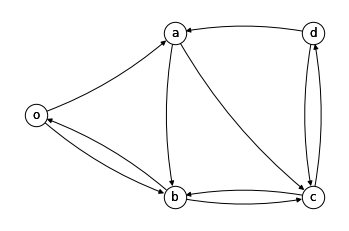

In [8]:
#defining and printing the give graph
nodes = ['o', 'a', 'b', 'c', 'd']
edges = [('o','a'), ('o','b'), ('a','b'), ('a','c'), ('b','c'), ('b','o'), 
         ('c','b'), ('c','d'), ('d','a'), ('d','c')]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = {'o': (40, 20), 'a': (60, 35), 'b': (60, 5), 'c':(80,5), 'd': (80, 35)}
node_list = list(G.nodes())


plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G, pos, with_labels=True, **options, connectionstyle="arc3,rad=0.1")
nx.draw_networkx_labels(G, pos)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

### Random-walk in discrete time function

In [4]:
# Simulates a random walk on the graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

def RandomWalk(G, xi, num_steps, till_first_return = False):
    # nodeSeq stores the sequence of visited nodes
    nodeSeq = []
    nodeSeq.append(xi)
    
    # if the walk ends at the first return to xi
    if till_first_return:
        # stores the initial position to check if the 
        # walk returns to it
        x_init = xi
        
        # no upper bound on the number of steps
        while True:
            # compute the next visited node xi by chosing uniformly
            # at random a neighbor of the current one
            xi = choice(G.adj[xi],1)[0]     
            nodeSeq.append(xi)
            
            # check if the walk has returned to the starting node
            # if so, end the walk
            if xi == x_init:
                return nodeSeq
    
    # if the walk ends after num_steps steps
    else:
        for i in range(num_steps):
            xi = choice(G.adj[xi],1)[0]      
            nodeSeq.append(xi)
        return nodeSeq

### Point *a*

We are using a global clock!

In [5]:
#defining Lambda
Lambda = np.array([
     [0, 2/5, 1/5, 0, 0],
     [0, 0, 3/4, 1/4, 0],
     [1/2, 0, 0, 1/2, 0],
     [0, 0, 1/3, 0, 2/3],
     [0, 1/3, 0, 1/3, 0]

])

#defining w for the clock in continuos time
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

#defining P_bar (we are in continuos time)
P_bar = Lambda/w_star 
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))



#Compute pi_bar the invariant probability vector by determining the leading eigenvector of the matrix Q′
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


#### Function to simulate the Continuos random walk

* *P_bar = the P_bar matrix of the graph* 
* *start_node, end_node = node to start and to end the walk*
* *steps = number of jump to do considered only if end_node is None*
* nSimulations = number of times to simulate the random walk


In [5]:
def SimulateParticle(P_bar, start_node, end_node, steps, nSimulations):
    # Compute the cumulative sums of the rows of P_bar to extract at each iteration the next state to visit
    P_cum = np.cumsum(P_bar, axis=1)
    times = np.array([])
    for sim in range(nSimulations):
        printProgressBar(sim+1,nSimulations)
        #print("simulation ", sim)
        pos = np.array([start_node])
        transition_times = np.array([0])
        t_next = -np.log(np.random.rand())/w_star


        continua = True
        i = 1
        while continua: 
            pos = np.append(pos, np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0])
            transition_times = np.append(transition_times,transition_times[i-1] + t_next)
            t_next = -np.log(np.random.rand())/w_star
            if end_node == pos[i]:
                times = np.append(times, transition_times[-1])
                continua = False
            elif end_node is None and i == steps:
                times = np.append(times, transition_times[-1])
                continua = False
            i += 1

    return times

In [6]:
times_array = SimulateParticle(P_bar, 1, 1, 0, 1000) #Takes about 8 mins to run with 500000
avg_time = times_array.sum()/len(times_array)
print("Empirical average time to return in a starting from a:",  avg_time)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Empirical average time to return in a starting from a: 6.686536628358894


In [7]:
times_array = SimulateParticle(P_bar, 1, 1, 0, 10000) #Takes about 2 mins to run with 10000
avg_time = times_array.sum()/len(times_array)
print("Empirical average time to return in a starting from a:",  avg_time)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Empirical average time to return in a starting from a: 6.703693272513589


In [9]:
times_array = SimulateParticle(P_bar, 1, 1, 0, 100000) #Takes about 6 mins to run with 100000
avg_time = times_array.sum()/len(times_array)
print("Empirical average time to return in a starting from a:",  avg_time)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Empirical average time to return in a starting from a: 6.7361704122869535


As the number of simulations grows the average time will converge to the theoretical value that we'll find in Point *b*

In [9]:

start_idx = node_list.index('a')
end_idx = node_list.index('a')
n_sim = 20000
times_array = SimulateParticle(P_bar, start_idx, end_idx, 0, n_sim) #Takes about 5 mins to run with 200000
avg_time = times_array.sum()/len(times_array)
print(f"Empirical average time to return in a starting from a on {n_sim} simulations:",  avg_time)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Empirical average time to return in a starting from a on 20000 simulations: 6.744347446016658


### Point *b*

The expected return times when the graph is strongly connected is:

$ \mathbb{E}_i[T^+_i] = \frac{1}{w_i\bar{\pi_i}}$ (Theorem 7.3)


In [10]:
def hittingTimesContinuous(G, P, w, S):
    n_nodes = G.number_of_nodes()

    # Define the set S and the remaining nodes R
    R = [node for node in range(n_nodes) if node not in S]

    # Restrict P to R x R to obtain hat(P)
    hatP = P[np.ix_(R, R)]
    hatw= w[np.ix_(R)]
    # np.linalg.solve solves a linear matrix equation given
    hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),np.ones(n_nodes-len(S))/hatw)
    # define the hitting times to the set S
    # hitting time is 0 if the starting node is in S
    hitting_s = np.zeros(n_nodes)
    # hitting time is hat(x) for nodes in R
    hitting_s[R] = hatx
    return hitting_s

In [11]:
def ExpectedReturnTimeContinuous(G, pi, w, target_node):
    idx = list(G.nodes()).index(target_node)
    return 1/(pi[idx]*w[idx])


In [12]:
node_list = list(G.nodes())
nodes_in_S = ['a']
S_call = [node_list.index(node) for node in nodes_in_S ]

#Compute matrices of graph G
P = np.linalg.inv(np.diag(w))@Lambda #normlized weight matrix


print("Expected return time:", ExpectedReturnTimeContinuous(G,pi_bar, w,'a'))

Expected return time: 6.750000000000008


### Point *c*

In [16]:
#change the start and end node
start_idx = node_list.index('o')
end_idx = node_list.index('d')

times_array = SimulateParticle(P_bar, start_idx, end_idx, 0, 1000)

avg_time_od = times_array.sum()/len(times_array)
print("Empirical average time from o to d:",  avg_time_od)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Empirical average time from o to d: 9.098438338853803


In [17]:
#change the start and end node
start_idx = node_list.index('o')
end_idx = node_list.index('d')

times_array = SimulateParticle(P_bar, start_idx, end_idx, 0, 10000) #Takes about 3 mins

avg_time_od = times_array.sum()/len(times_array)
print("Empirical average time from o to d:",  avg_time_od)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Empirical average time from o to d: 8.863418763159004


In [18]:
#change the start and end node
start_idx = node_list.index('o')
end_idx = node_list.index('d')

times_array = SimulateParticle(P_bar, start_idx, end_idx, 0, 100000) #takes about 6 mins 

avg_time_od = times_array.sum()/len(times_array)
print("Empirical average time from o to d:",  avg_time_od)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Empirical average time from o to d: 8.743283829515795


### Point *d*

In [24]:
#Already used the functions to calculate
#hitting times of all nodes 
nodes_in_S = ['d']
S_call = [node_list.index(node) for node in nodes_in_S ]
hitting_times = hittingTimesContinuous(G, P, w, S_call)
#Take the start_idx element of the hitting_time array
print("Thoretical hitting time from o to d:",  hitting_times[start_idx])

Thoretical hitting time from o to d: 8.785714285714285


As the number of simulations goes to infinite the empirical value will be closer to the theoretical one.

### Point *e*

In [34]:
#Already constructed P 
#redraw for a moment the graph

#number of iterations
n_iter = 70

# ksave the evolution of the consensus
x = np.zeros((G.number_of_nodes(),n_iter))

# set initial condition (1,0,0,0,1)
x[:,0] = np.random.rand(G.number_of_nodes())
# evolve the states
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]
    
x[:,n_iter-1]

array([0.26176659, 0.26176659, 0.26176659, 0.26176659, 0.26176659])

In [35]:
values,vectors = np.linalg.eig(P.T)

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(values[i],1)]: 
    pi = vectors[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi)
#found pi, we have to multiply by the initial condition
x0 = x[:,0]


print("The consensus value is:", pi@x0)

The consensus value is: 0.26176659219349563


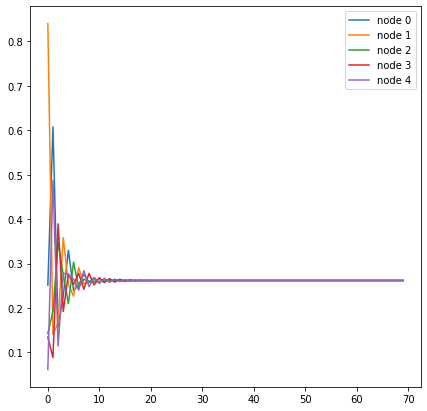

In [36]:
#plot the record of the consensus vector to have a better look of the convergence
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

### Point *f*

##### Wisdom of crowds
Consider a graph, and assume that state of each node represents a noisy estimate of the real state $\mu$, i.e.,

$$
x_i = \mu + y_i,
$$

with $E[y_i]=0$, and the variance $\sigma^2 (y_i) = \sigma^2$ for each $i$.

Assume that the nodes of the graph talk each other, and assume that the graph is connected and aperiodic.
Eventually, they will reach to consensus, i.e., $\lim_{t \to +\infty} x(t) = \alpha \mathbf{1}$. 

Since $\alpha = \pi' (\mu \mathbf{1} + y)$, then

$$
E[\alpha] = \mu + \pi' E[y] = \mu, \quad \sigma_{\alpha}^2 = \sigma^2 \sum_{i} \pi_i^2 < \sigma^2,
$$

because $\sum_{i} \pi_i^2 <1$ if the graph has more than one node.

Obviously, $E[\alpha]=\mu$, because the noise $y_i$ is unbiased for each $i$. However, the interesting observation is that the estimate $\alpha$ has a smaller variance than $\sigma$, i.e., the crowd is able to reconstruct a more precise estimate of the real state than the single agents of the graph.

In [38]:
mu = 1/2
var = 1/12
theo_sigma_alpha = var*np.sum(pi*pi)

n_sim = 1000
quad_err = np.zeros(n_sim)
#evolution of the dynamics
for sim in range(n_sim):
    x0 = np.random.rand(G.number_of_nodes())
    x = x0
    for n in range(15): #n_iter from previous dynamics 
        x = P @ x
    consensus_mean = np.mean(x)
    quad_err[sim] = (mu - consensus_mean) * (mu - consensus_mean)
    

#the variance sigma_alpha will be the mean of the quadratic error of each simulation
print("Expected value of the consensus value (alpaha):", sum(pi_bar*mu))
print("Thoretical variance of the consensus value (alpaha):", theo_sigma_alpha )
print()
print("Variance of the starting state:", var)
print("Variance of the consensus value (alpaha):", np.mean(quad_err))
print("The variance of the consensus value is always less than the variance of initial state")
### inizio pagina per spiegazione


Expected value of the consensus value (alpaha): 0.5
Thoretical variance of the consensus value (alpaha): 0.017800882167611845

Variance of the starting state: 0.08333333333333333
Variance of the consensus value (alpaha): 0.017159523681594294
The variance of the consensus value is always less than the variance of initial state


### Point *g*

In [6]:
def removeEdgeFromW(edge, W, nodes):
    start = nodes.index(edge[0])
    end = nodes.index(edge[1])
    print(W[start,end],"->",0)
    W[start,end] = 0
    return W

In [9]:
import copy
#Removing (d,a) and (d,c)
W1 = Lambda.copy()
W1 = removeEdgeFromW(('d','a'), W1, node_list)
W1 = removeEdgeFromW(('d','c'), W1, node_list)

0.3333333333333333 -> 0
0.3333333333333333 -> 0


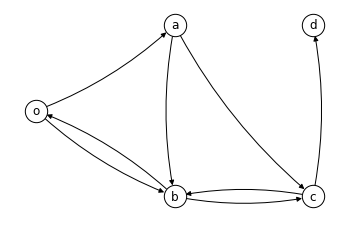

In [10]:
G1 = nx.convert_matrix.from_numpy_matrix(W1, parallel_edges=True,create_using = nx.DiGraph)
mapping = {
    0:'o',
    1:'a',
    2:'b',
    3:'c',
    4:'d'
}
G1 = nx.relabel_nodes(G1, mapping)
plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G1, pos,with_labels=True, **options, connectionstyle="arc3,rad=0.1")
#nx.draw_networkx_labels(G)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

Node $d$ has out-degree 0. We need to add a self loop

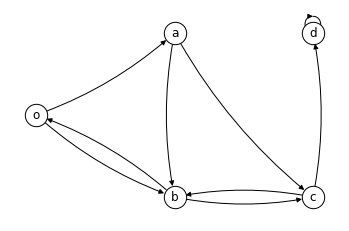

In [11]:
G1.add_edge('d','d')
plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G1, pos,with_labels=True, **options, connectionstyle="arc3,rad=0.1")
#nx.draw_networkx_labels(G)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

In [12]:
#construct P
W1 = nx.adjacency_matrix(G1)
W1 = W1.toarray()
degrees1 = np.sum(W1,axis=1)
D1 = np.diag(degrees1)
P1 = np.linalg.inv(D1) @ W1

In [13]:
def computeConsensusValue(P, x0):
    values,vectors = np.linalg.eig(P.T)

    # selects the eigenvalue 1 and print the eigenvector
    for index in [i for i in range(P.shape[0]) if np.isclose(values[i],1)]: 
        pi = vectors[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
        pi = pi/np.sum(pi)
    #print(pi)
    #found pi, we have to multiply by the initial condition
    return x0, pi@x0

In [14]:
initial, value = computeConsensusValue(P1, [0,0,0,0,1])
print("Initial state:", initial)
print("Consensus value:", value)
print()
initial, value = computeConsensusValue(P1, [10,0,0,0,1])
print("Initial state:", initial)
print("Consensus value:", value)
print()
initial, value = computeConsensusValue(P1, [94,43,32,1,0])
print("Initial state:", initial)
print("Consensus value:", value)
print()

Initial state: [0, 0, 0, 0, 1]
Consensus value: 1.0

Initial state: [10, 0, 0, 0, 1]
Consensus value: 1.0

Initial state: [94, 43, 32, 1, 0]
Consensus value: 0.0



In [19]:
#Simulating the dynamic evolution
x0 = [10,0,0,0,1]
x=x0
n_iter = 100
for n in range(n_iter): 
    printProgressBar(n+1, n_iter)
    #n_iter from previous dynamics 
    x = P1 @ x
initial, value = computeConsensusValue(P1, x0)
print("Consensus value:", value)
print("Initial state:", x0)
print("Empirical consensus value:", x.mean())
print()


x0 = [94,43,32,1,0]
x=x0
n_iter = 100
for n in range(n_iter): 
    printProgressBar(n+1, n_iter)
    #n_iter from previous dynamics 
    x = P1 @ x
initial, value = computeConsensusValue(P1, x0)
print("Consensus value:", value)
print("Initial state:", x0)
print("Empirical consensus value:", x.mean())
print()



n_iter = 100
x0 = np.random.rand(G1.number_of_nodes())
x=x0
for n in range(n_iter): #n_iter from previous dynamics 
    printProgressBar(n+1, n_iter)
    x = P1 @ x
initial, value = computeConsensusValue(P1, x0)
print("Consensus value:", value)
print("Initial state:", x0)
print("Empirical consensus value:", x.mean())
print()

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Consensus value: 1.0
Initial state: [10, 0, 0, 0, 1]
Empirical consensus value: 1.000000003343278

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Consensus value: 0.0
Initial state: [94, 43, 32, 1, 0]
Empirical consensus value: 1.1533418789138377e-07

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished

Consensus value: 0.490910984036105
Initial state: [0.37035301 0.58321031 0.69857046 0.24992079 0.49091098]
Empirical consensus value: 0.49091098403351746



Empirical values obtained are compatible with theoretical values

#### Considering initial state as random variable

In [20]:
#Compute pi_bar the invariant probability vector by determining the leading eigenvector of the matrix Q′
values1,vectors1 = np.linalg.eig(P1.T)
index1 = np.argmax(values1.real)
pi1 = vectors1[:,index1].real
pi1 = pi1/np.sum(pi1)
print("pi=", pi1)

pi= [0. 0. 0. 0. 1.]


In [21]:
mu = 1/2
var = 1/12
theo_sigma_alpha1 = var*np.sum(pi1*pi1)

n_sim = 1000
quad_err1 = np.zeros(n_sim)
consensus_arrays = np.zeros((int(n_sim/100),G1.number_of_nodes())) 
initial_arrays = np.zeros((int(n_sim/100),G1.number_of_nodes()))
#evolution of the dynamics
for sim in range(n_sim):
    printProgressBar(sim+1, n_sim)
    x0 = np.random.rand(G1.number_of_nodes())
    x = x0
    for n in range(200): #n_iter from previous dynamics 
        x = P1 @ x
    consensus_mean = np.mean(x)
    if sim%100 == 0:
        consensus_arrays[int(sim/100),:] = x
        initial_arrays[int(sim/100),:] = x0
    quad_err1[sim] = (mu - consensus_mean) * (mu - consensus_mean)

print()
for i,el in enumerate(consensus_arrays):
    print("consensus[", i, "]:", el, "-> x0['d']=", initial_arrays[i,4])
print()
#the variance sigma_alpha will be the mean of the quadratic error of each simulation
print("Expected value of the consensus value (alpaha):", sum(pi1*mu))
print("Thoretical variance of the consensus value (alpaha):", theo_sigma_alpha1 )
print()
print("Variance of the starting state:", var)
print("Variance of the consensus value (alpaha):", np.mean(quad_err1))
### inizio pagina per spiegazione


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished


consensus[ 0 ]: [0.97405112 0.97405112 0.97405112 0.97405112 0.97405112] -> x0['d']= 0.9740511235552235
consensus[ 1 ]: [0.70266617 0.70266617 0.70266617 0.70266617 0.70266617] -> x0['d']= 0.7026661702905794
consensus[ 2 ]: [0.70523198 0.70523198 0.70523198 0.70523198 0.70523198] -> x0['d']= 0.7052319788500222
consensus[ 3 ]: [0.99808637 0.99808637 0.99808637 0.99808637 0.99808637] -> x0['d']= 0.9980863744317052
consensus[ 4 ]: [0.77129858 0.77129858 0.77129858 0.77129858 0.77129858] -> x0['d']= 0.7712985780172144
consensus[ 5 ]: [0.69188417 0.69188417 0.69188417 0.69188417 0.69188417] -> x0['d']= 0.6918841718047309
consensus[ 6 ]: [0.88302954 0.88302954 0.88302954 0.88302954 0.88302954] -> x0['d']= 0.8830295387697321
consensus[ 7 ]: [0.48282149 0.48282149 0.48282149 0.48282149 0.48282149] -> x0['d']= 0.48282149277858377
consensus[ 8 ]: [0.83666099 0.83666099 0.836

The consensus value now converges to the initial state of 'd', so the variance of the consensus value is the same as the initial states variance, because states of 'd' along all simulations are distributed as the initial states assigned to the nodes. 

### Point *h*

In [22]:
import copy
#Removing (d,a) and (d,c)
W2 = Lambda.copy()
W2 = removeEdgeFromW(('c','b'), W2, node_list)
W2 = removeEdgeFromW(('d','a'), W2, node_list)

0.3333333333333333 -> 0
0.3333333333333333 -> 0


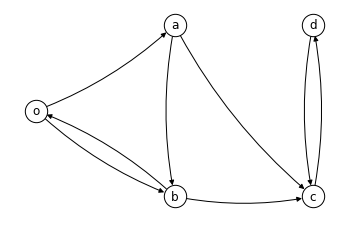

In [23]:
G2 = nx.convert_matrix.from_numpy_matrix(W2, parallel_edges=True,create_using = nx.DiGraph)
mapping = {
    0:'o',
    1:'a',
    2:'b',
    3:'c',
    4:'d'
}
G2 = nx.relabel_nodes(G2, mapping)
plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G2, pos,with_labels=True, **options, connectionstyle="arc3,rad=0.1")
#nx.draw_networkx_labels(G)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

In [25]:
degrees2 = W2.sum(axis=1)
D2 = np.diag(degrees2)
P2 = np.linalg.inv(D2) @ W2

In [26]:
x0 = [0,0,0,0,1]
x=x0
n_iter = 1000
for n in range(n_iter): #n_iter from previous dynamics
    printProgressBar(n+1, n_iter)
    x = P2 @ x
print()
print("Initial states:", x0)
print("Consensus:", x)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished


Initial states: [0, 0, 0, 0, 1]
Consensus: [0.46153846 0.42307692 0.76923077 0.         1.        ]


The dynamics seems to not converge. We can try to study the evolution obtaining that it oscillates.

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished


[11.61538461 11.73076923 10.69230769 13.         10.        ]


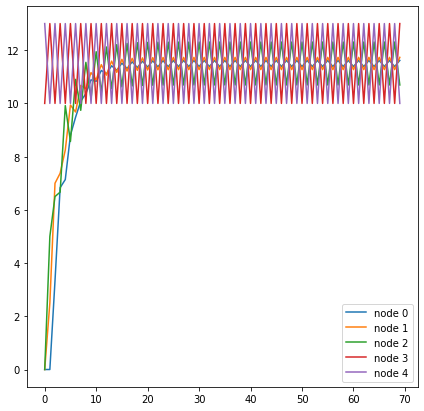

In [27]:
#Already constructed P 
#redraw for a moment the graph

#number of iterations
n_iter = 70

# ksave the evolution of the consensus
x = np.zeros((G2.number_of_nodes(),n_iter))

# set initial condition (0,0,0,0,1)
x[4,0] = 13
x[3,0] = 10

# evolve the states
for t in range(1,n_iter):
    printProgressBar(t+1, n_iter)
    x[:,t] = P2 @ x[:,t-1]
print()    
print(x[:,n_iter-1])

#plot the record of the consensus vector to have a better look of the convergence
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(G2.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

But if the initial of nodes D and C is the same, the dynamic will converge. Here some tries:

[0.4679 0.3616 0.2771 1.     1.    ]
[0.8525 0.4262 0.6882 7.     7.    ]
[0.1445 0.7719 0.3533 4.     4.    ]
[0.2118 0.341  0.5384 2.     2.    ]


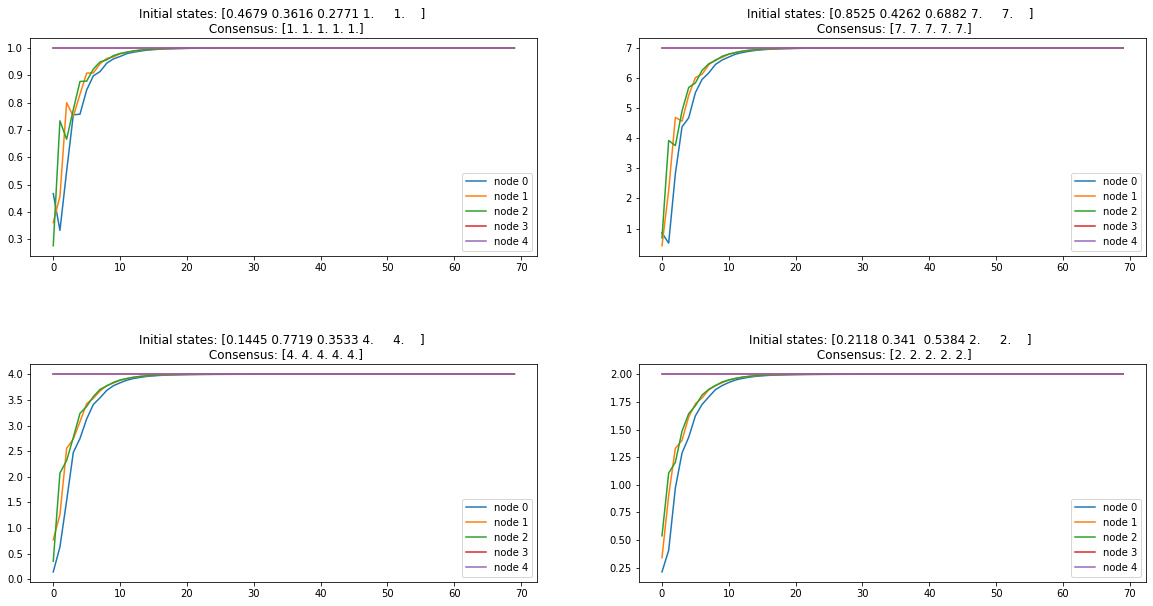

In [34]:
import matplotlib
#defining a list of value to try as inital state of C and D
initial_list = np.random.rand(4)
initial_list = initial_list*10
initial_list = initial_list.astype(np.int32)
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, gridspec_kw={'width_ratios':[0.5, 0.5], 'height_ratios':[0.5, 0.5], 'hspace':0.5})
fig.set_figheight(10)
fig.set_figwidth(20)
for i,el in enumerate(initial_list):
    x = np.zeros((G2.number_of_nodes(),n_iter)) #keep track of the evolution of states 
    x[:,0] = [np.random.rand(1) for _ in x[:,0]] #start with random state for nodes O A B, to be sure dynamics is not influenced by their initial state
    #set initial state of C and D at the sem value from the list above
    x[3,0] = el 
    x[4,0] = el
    
    # evolve the states
    for t in range(1,n_iter):
        x[:,t] = P2 @ x[:,t-1]

    
    #plot the record of the consensus vector to have a better look of the convergence
    #imgaxes.append(plt.subplot(gs[int(i / 4), i % 4]))
    #fig = plt.figure(i, figsize=(7,7))
    #ax = plt.subplot(111)

    for node in range(G2.number_of_nodes()):
        trajectory = x[node,:]
        axes[int(i / 2),  i % 2].plot(trajectory, label='node {0:d}'.format(node))
        axes[int(i / 2),  i % 2].set_title("Initial states: {} \n Consensus: {}".format( np.round(x[:,0],decimals=4),np.round(x[:,n_iter-1])))
        axes[int(i / 2),  i % 2].legend()
    #ax.legend()
    #ax.set_title("Initial states: {} \n Consensus: {}".format( np.round(x[:,0],decimals=3),np.round(x[:,n_iter-1])))
    
    print(np.round(x[:,0],decimals=4))

## Problem 2

In [120]:
def particlePerspectiveParticleClock(P_bar, start_node, end_node, time, nSimulations, nParticle):
    particles = np.array(range(nParticle)) 
    # Compute the cumulative sums of the rows of P_bar to extract at each iteration the next state to visit
    P_cum = np.cumsum(P_bar, axis=1)
    times = np.zeros((nParticle, nSimulations))
    positions = []
    print(positions)
    for par in particles:
        printProgressBar(par+1, len(particles))
        for sim in range(nSimulations):
            tot_time = 0
            #print("simulation ", sim)
            pos = np.array([start_node])
            transition_times = np.array([0])
            t_next = -np.log(np.random.rand())/w_star 
            continua = True
            i = 1
            while continua: 
                pos = np.append(pos, np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0])
                transition_times = np.append(transition_times,transition_times[i-1] + t_next)
                t_next = -np.log(np.random.rand())/w_star
                if end_node == pos[i]:
                    times[par,sim] = transition_times[-1]
                    positions.append(pos)
                    continua = False
                elif end_node is None and tot_time >= time:
                    positions.append(pos)
                    times[par,sim] = transition_times[-1]
                    continua = False
                tot_time += t_next
                i += 1

    if nParticle > 1:
        return times.mean(axis=1) #returning mean for each particle
    else: 
        return positions, times

In [53]:
l = particlePerspectiveParticleClock(P_bar, 1, 1, 0, 100, 100)
print()
print("Average return time over 100 particles:", l.mean())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished


Average return time over 100 particles: 6.789006555531937


In [37]:
import copy
def NodePerspectiveGlobalClock(P_bar, start_node, time, nParticles):
    nodes = np.array(range(G.number_of_nodes()))
    transition_times = [0]
    particles_in_nodes = np.zeros((G.number_of_nodes(),100000))
    particles_in_nodes[start_node][0] = nParticles
    #print(particles_in_nodes)
    P_cum = np.cumsum(P_bar, axis=1)
    tot_time = 0
    t_next = -np.log(np.random.rand())/100
    tot_time = tot_time + t_next
    i=1
    while tot_time <= time:
        transition_times.append(tot_time)
        #print("Step {}".format(i))
        sel_node = np.random.choice(nodes, 1, p = (np.array(particles_in_nodes[:,i-1])/100))[0]#select node from which to move a particle
        #sel_node = np.argmax(particles_in_nodes[:,i-1]) 
        #print("max: {}, at index: {} in {}".format(np.max(particles_in_nodes[:,i-1]),sel_node,particles_in_nodes[:,i-1]))
        new_pos = np.argwhere(P_cum[sel_node] > np.random.rand())[0]
        #print("Move particle from {} to {}".format(sel_node, new_pos))
        if new_pos != sel_node and particles_in_nodes[sel_node,i-1]>0:
            #print("coping old in new and proceed")
            particles_in_nodes[:,i]= particles_in_nodes[:,i-1]
            #print(particles_in_nodes[:,i-1:i])
            #print("modify nodes")
            particles_in_nodes[sel_node,i]= particles_in_nodes[sel_node,i] - 1
            particles_in_nodes[new_pos,i] = particles_in_nodes[new_pos,i] + 1
        else: 
            #print("only copy old in new")
            particles_in_nodes[:,i]= particles_in_nodes[:,i-1]
        t_next = -np.log(np.random.rand())/100
        tot_time = tot_time + t_next
        i += 1
    
    return particles_in_nodes, i, transition_times

In [162]:
simulations = 50
final_states = np.zeros((G.number_of_nodes(), simulations))
for sim in range(simulations):
    printProgressBar(sim+1, simulations)
    nodes_evolution, tot_steps, transitions = NodePerspectiveGlobalClock(P_bar, 0, 60, 100)
    final_states[:,sim] = nodes_evolution[:,tot_steps-1]

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



In [166]:
print("Average number of particles in each node: ", np.round(np.mean(final_states, axis=1), decimals=4))

Average number of particles in each node:  [18.74 14.92 22.5  22.3  21.54]


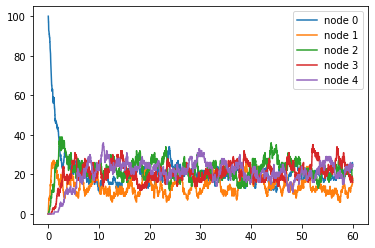

In [62]:
fig = plt.figure()
ax = plt.axes()

x = range(tot_steps)
for n in range(5):
    ax.plot(transitions, nodes_evolution[n,:tot_steps],label='node {0:d}'.format(n))
    ax.legend()

In [164]:
np.mean(final_states, axis=1)/100, pi_bar

(array([0.1874, 0.1492, 0.225 , 0.223 , 0.2154]),
 array([0.18518519, 0.14814815, 0.22222222, 0.22222222, 0.22222222]))

## Problem 3

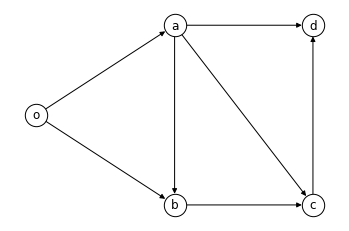

In [169]:
#transition rate matrix
Lambda = np.array([
    [0,2/3,1/3,0,0],
    [0,0,1/4,1/4,2/4],
    [0,0,0,1,0],
    [0,0,0,0,1],
    [0,0,0,0,0]
])
#in this exercise the state space is X={o,a,b,c,d}

import copy
#Removing (d,a) and (d,c)
W3 = Lambda.copy()
G3 = nx.convert_matrix.from_numpy_matrix(W3, parallel_edges=True,create_using = nx.DiGraph)
mapping = {
    0:'o',
    1:'a',
    2:'b',
    3:'c',
    4:'d'
}
G3 = nx.relabel_nodes(G3, mapping)
plt.subplot(111)
#nx.draw_networkx_nodes(G, pos, node_color=options['node_color'], node_size=options['node_size'],)
#nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, min_source_margin=16, min_target_margin=16)
nx.draw(G3, pos,with_labels=True, **options, connectionstyle="arc3,rad=0")
#nx.draw_networkx_labels(G)
ax= plt.gca()
ax.collections[0].set_edgecolor("black")

In [170]:
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
P_bar = Lambda/w_star
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar, axis=1))

values, vector = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vector[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=",pi_bar)

pi_bar= [0. 0. 0. 0. 1.]


### Point *a*

In [171]:
def get_starting_node(number_of_nodes, node_particles, rate):
    particles = rate

    
    with_dummy = np.zeros(number_of_nodes+1) #+1 for dummy node o' that sends particles to o
    with_dummy[-1] = rate #put rate particle in o'

    particles += np.sum(node_particles) #save the total number of particles in the graph

    for i in range(number_of_nodes):
        with_dummy[i] = node_particles[i] #save number of particles in node in the variable with dummy node o'
    
    #decide which node moves
    with_dummy_cum = np.cumsum(with_dummy)/particles 
    start_node = np.argwhere(with_dummy_cum > np.random.rand())[0][0]
    if(start_node == number_of_nodes):##node o' is selected
        start_node = -1
    return start_node, particles


def proportional_rate_simulation(G, P_bar, input_rate, time, exit_node_idx, access_node_idx):
    #particles in node
    node_particles = np.zeros(G.number_of_nodes())

    transition_times = []
    transition_times.append(0)
    
    
    hist_nodes = np.zeros((G.number_of_nodes(),1))

    P_cum = np.cumsum(P_bar, axis=1)

    tot_time = 0
    i=1
    while tot_time <= time:
        #print("\r{:.2f}/{}\r".format(tot_time, time), end="")
        start_node, particles = get_starting_node(G.number_of_nodes(), node_particles, input_rate)
        
        
        # check dummy variable
        if start_node == -1: #if starting node is o'
            node_particles[access_node_idx] += 1 #add particle to node o
            t_next = -np.log(np.random.rand()) / input_rate 

        elif start_node == exit_node_idx: #if node starting node is node d
            t_next = -np.log(np.random.rand()) / node_particles[exit_node_idx]
            node_particles[exit_node_idx] -= 1  #decrease particle in node d

        else: #if starting node is another node 
            t_next = -np.log(np.random.rand()) / node_particles[start_node]
            end_node = np.argwhere(P_cum[start_node] > np.random.rand())[0][0] #find the end node 
            node_particles[start_node] -= 1 #decrese particle in starting node
            node_particles[end_node] += 1 #increse particles in ending node
            
        tot_time += t_next
        
        printProgressBar(tot_time, time)
        transition_times.append(tot_time)
        
        #if i%1000 == 0:
        hist_nodes = np.append(hist_nodes, node_particles.reshape(G.number_of_nodes(),1), axis=1)
        i += 1 

    return hist_nodes, transition_times
                                         



 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=1')

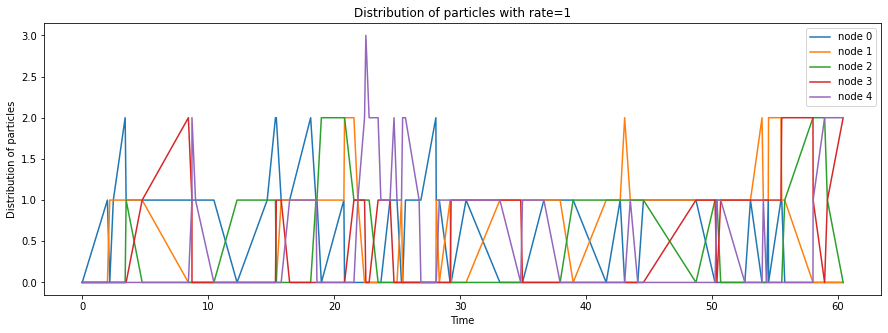

In [172]:
input_rate = 1 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = proportional_rate_simulation(G,P_bar,input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=10')

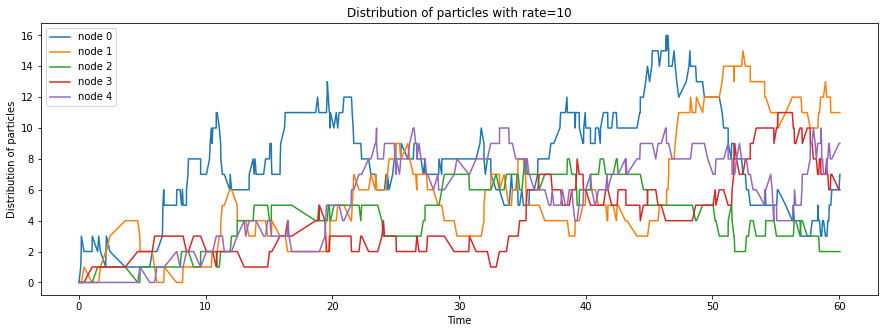

In [173]:
input_rate = 10 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = proportional_rate_simulation(G,P_bar,input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=100')

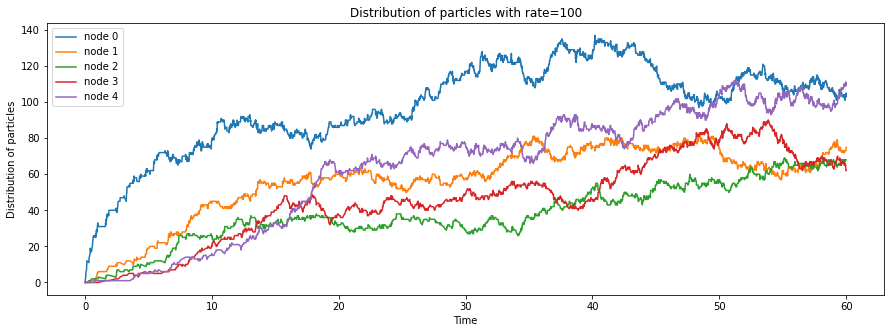

In [174]:
input_rate = 100 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = proportional_rate_simulation(G,P_bar,input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=500')

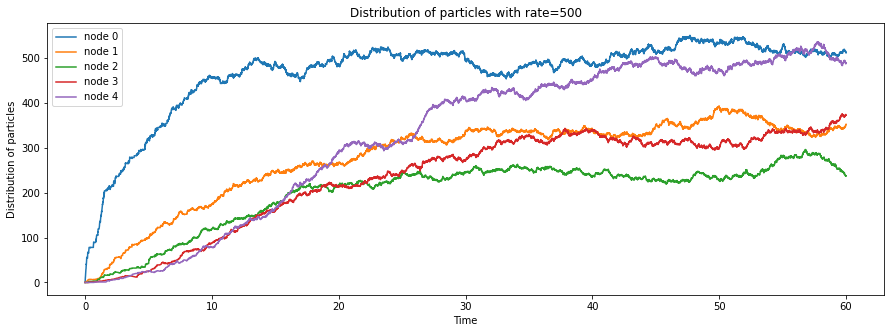

In [395]:
input_rate = 500 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = proportional_rate_simulation(G,P_bar,input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

### Point *b*

In [176]:
def fixed_rate_simulation(G, P_bar, rate, input_rate, time, exit_node_idx, access_node_idx):
    #particles in node
    node_particles = np.zeros(G.number_of_nodes())

    transition_times = []
    transition_times.append(0)
    
    hist_nodes = np.zeros((G.number_of_nodes(),1))

    P_cum = np.cumsum(P_bar, axis=1)

    tot_time = 0
    i=1
    while tot_time <= time:
        #print("\r{:.2f}/{}\r".format(tot_time, time), end="")
        start_node, particles = get_starting_node(G.number_of_nodes(), node_particles, input_rate)
        
        t_next = -np.log(np.random.rand()) / rate
        # check dummy variable
        if start_node == -1: #if starting node is o'
            #t_next = -np.log(np.random.rand()) / input_rate
            node_particles[access_node_idx] += 1 #add particle to node o

        elif start_node == exit_node_idx: #if node starting node is node d
            #t_next = -np.log(np.random.rand()) / node_particles[exit_node_idx]
            node_particles[4] -= 1  #decrease particle in node d

        else: #if starting node is another node 
            #t_next = -np.log(np.random.rand()) / node_particles[start_node]
            end_node = np.argwhere(P_cum[start_node] > np.random.rand())[0][0] #find the end node 
            node_particles[start_node] -= 1 #decrese particle in starting node
            node_particles[end_node] += 1 #increse particles in ending node
            
        tot_time += t_next
        printProgressBar(tot_time, time)
        transition_times.append(tot_time)
        
        #if i%1000 == 0:
        hist_nodes = np.append(hist_nodes, node_particles.reshape(G.number_of_nodes(),1), axis=1)
        i += 1 

    return hist_nodes, transition_times

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=1')

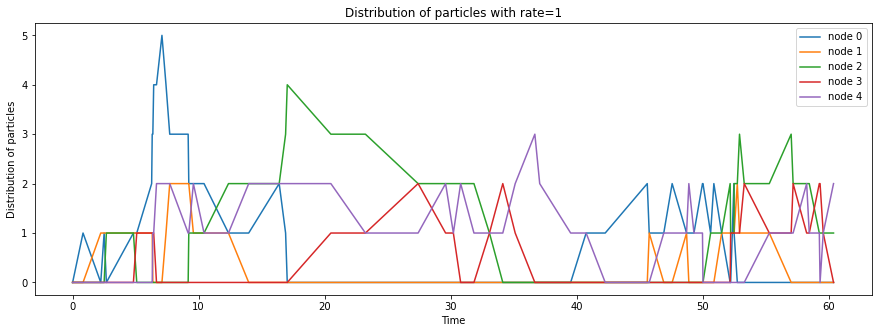

In [177]:
fixed_rate = 1 
input_rate = 1 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = fixed_rate_simulation(G,P_bar,fixed_rate, input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=10')

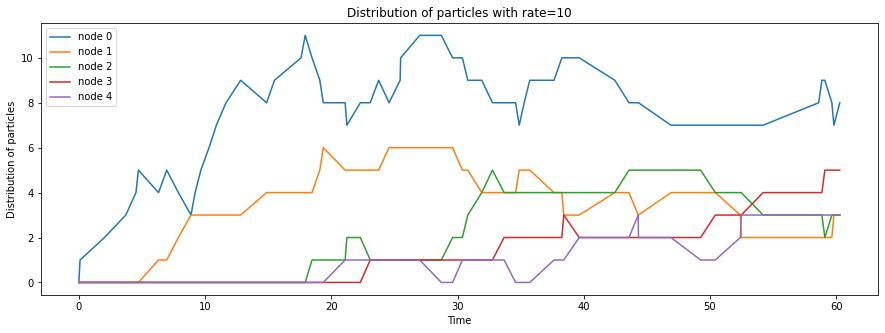

In [178]:
fixed_rate = 1 
input_rate = 10 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = fixed_rate_simulation(G,P_bar,fixed_rate, input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

In [419]:
part_dist_time[4,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 2., 2., 1., 2., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 3., 3., 4., 4.])

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=100')

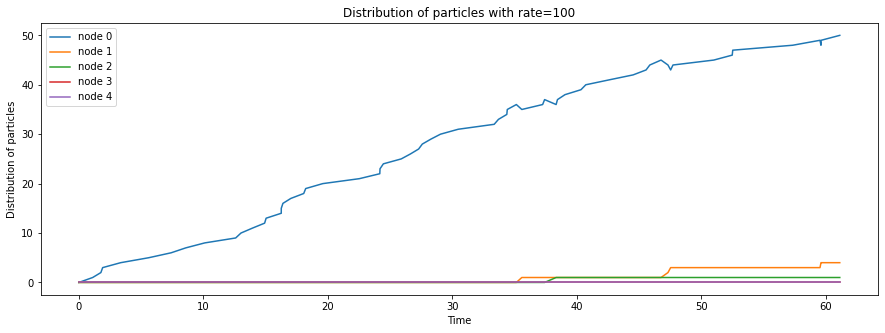

In [179]:
fixed_rate = 1 
input_rate = 100 #number of particles that enters in the graph
time_limit = 60
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = fixed_rate_simulation(G,P_bar,fixed_rate, input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

In [417]:
part_dist_time[4,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% % 
Finished



Text(0.5, 1.0, 'Distribution of particles with rate=50')

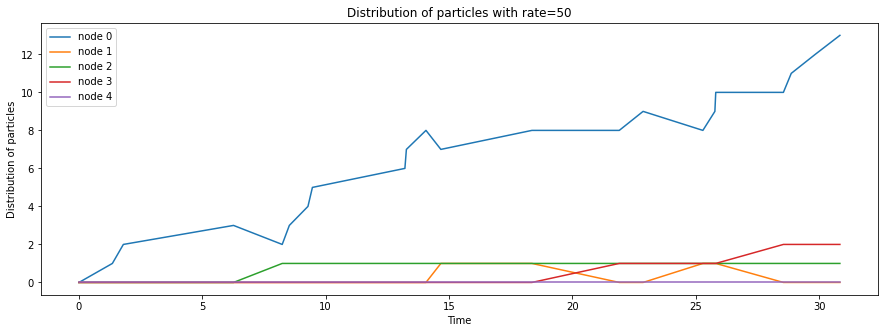

In [187]:
fixed_rate = 1 
input_rate = 50 #number of particles that enters in the graph
time_limit = 30
exit_node = node_list.index('d')
access_node = node_list.index('o')

part_dist_time, transition_times = fixed_rate_simulation(G,P_bar,fixed_rate, input_rate,time_limit,exit_node, access_node)


fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node,:len(transition_times)],label="node {}".format(node))
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()
plt.title(f"Distribution of particles with rate={input_rate}")

In [188]:
part_dist_time[:,-1]

array([13.,  0.,  1.,  2.,  0.])